### https://arxiv.org/abs/2104.09864

In [1]:
from torch import nn
import torch

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


class RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None, scaling_factor= None, dynamic_scale=False):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        assert ((dynamic_scale and scaling_factor is not None) and scaling_factor <= 1) or not dynamic_scale
        self.scaling_factor=scaling_factor
        self.dynamic_scale = dynamic_scale
        angular_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim)) # (d/2, )
        self.register_buffer("angular_freq", tensor=angular_freq, persistent=False)

    @torch.no_grad()
    def re_initialize_angular_freq(self, seq_len):
        if seq_len > self.max_position_embeddings:
            base = self.base * (
                (self.scaling_factor * seq_len / self.max_position_embeddings) - (self.scaling_factor - 1)
            ) ** (self.dim / (self.dim - 2))
            print("new_base" ,base)
            angular_freq = 1.0 / (
                base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float().to(x.device) / self.dim)
            )
            self.register_buffer("angular_freq", angular_freq, persistent=False)
    
    @torch.no_grad()
    def forward(self, x, position_ids):
        """
        x -> (b x h x s x d)
        positions_ids = (1 x s)
        """
        seq_len = torch.max(position_ids) + 1
        if self.dynamic_scale:
            self.re_initialize_angular_freq(seq_len)
    
        
        if self.angular_freq.device != x.device:
            self.angular_freq.to(x.device)
        
        # (b x d/2 x 1)
        inv_freq_expanded = self.angular_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)

        #(b x 1 x s)
        position_ids_expanded = position_ids[:, None, :].float()

        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            # (b x d/2 x 1) @ (b x 1 x s) -> (b x s x d/2)
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            # (b x s x d)
            emb = torch.cat((freqs, freqs), dim=-1)
            
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

## What we are doing?

We calculate the cosine and sine values based on the position and a dimension-dependent rotation frequency, where the wavelength is a monotonically decreasing function with respect to the dimension. The formula for the angular frequency is:

$${angular\_rotation} = \frac{1}{10000^{2i/d}}$$

Multiplying this factor by the position gives the frequency at which the vector rotates, based on its position in the sequence.

In [2]:
def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

Rotary Position Embedding (RoPE) is applied to the query and key tensors as follows:

1. The input vector \( q \) is split into two halves: \( x_1 \) and \( x_2 \), where both \( x_1 \) and \( x_2 \) belong to the real space of dimension \( d/2 \).

2. The **rotation operation** is defined as:
$${rotate\_half} = (-x_2, x_1)$$

3. The final calculation after applying RoPE is performed as:
$${output} = \left[(x_1 \cdot \cos + (-x_2) \cdot \sin), (x_2 \cdot \cos + x_1 \cdot \sin)\right]$$

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rotation_of_vector(original, rotated, seq_len):
    colors = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(seq_len)]
    plots = []
    for i in range(seq_len):
        origin = np.array([[0, 0],[0, 0]]) # origin point
        
        plt.quiver(0, 0, original[i,0], original[i,1], color=[colors[i]], scale=4)
        
        plt.quiver(0,0, rotated[i,0], rotated[i,1], color=[colors[i]], scale=4)
        plt.text(rotated[i, 0]/ (25), rotated[i, 1]/(25), f"Rotated V{i+1}", color=colors[i])

In [23]:
seq_len = 4
din = 2
rope = RotaryEmbedding(din, dynamic_scale=True, scaling_factor=0.9)

x = torch.rand((1, 1, seq_len, din)).float()

In [24]:
position_id = torch.arange(seq_len).unsqueeze(0)

cos, sin = rope(x, position_id)

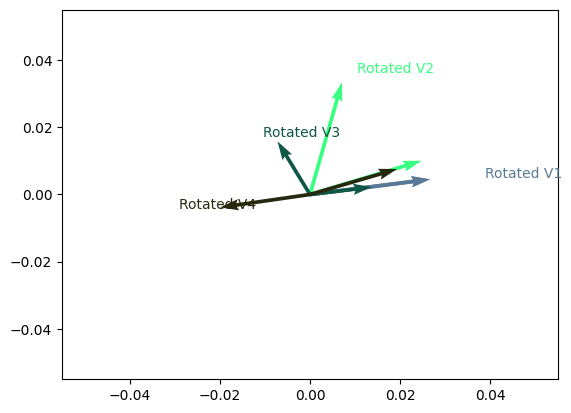

In [25]:
V = x[0, 0, ...].numpy()
rotated = apply_rotary_pos_emb(x, x, cos, sin)[0][0,0, ...]


plot_rotation_of_vector(V, rotated, seq_len)

## will the magnitude of the vector will be changed?

No, the magnitude of the vector will **not change** when applying the Rotary Position Embedding (RoPE). This is because RoPE applies a **rotation** to the embedding vectors, and rotations are **length-preserving transformations**. The rotation is done using the trigonometric cosine and sine functions, which do not alter the vector's magnitude, only its direction.

### Why the Magnitude Doesn't Change:

- When you apply a 2D rotation to a vector $(x_1, x_2)$ using the transformation:
  $$x_{\text{rotated}} = \begin{bmatrix} x_1 \cdot \cos(\theta) - x_2 \cdot \sin(\theta) \\ x_1 \cdot \sin(\theta) + x_2 \cdot \cos(\theta) \end{bmatrix}$$
  This transformation is simply a **rotation matrix** applied to the vector. A rotation matrix is known to preserve the Euclidean norm (magnitude) of a vector.

### Proof that Magnitude is Preserved:

Let’s say we have a vector $\mathbf{v} = [x_1, x_2]$ with the magnitude (or norm):
$$|\mathbf{v}| = \sqrt{x_1^2 + x_2^2}$$

After applying the RoPE transformation, we get the rotated vector:
$$\mathbf{v}_{\text{rotated}} = \begin{bmatrix} x_1 \cdot \cos(\theta) - x_2 \cdot \sin(\theta) \\ x_1 \cdot \sin(\theta) + x_2 \cdot \cos(\theta) \end{bmatrix}$$

Now, let's compute the magnitude of the rotated vector:
$$
|\mathbf{v}_{\text{rotated}}| = \sqrt{(x_1 \cdot \cos(\theta) - x_2 \cdot \sin(\theta))^2 + (x_1 \cdot \sin(\theta) + x_2 \cdot \cos(\theta))^2}
$$

Expanding the terms inside the square root:
$$
= \sqrt{(x_1^2 \cdot \cos^2(\theta) + x_2^2 \cdot \sin^2(\theta) - 2x_1x_2 \cdot \cos(\theta) \sin(\theta)) + (x_1^2 \cdot \sin^2(\theta) + x_2^2 \cdot \cos^2(\theta) + 2x_1x_2 \cdot \cos(\theta) \sin(\theta))}$$

Simplifying the expression:
$$
= \sqrt{x_1^2 \cdot (\cos^2(\theta) + \sin^2(\theta)) + x_2^2 \cdot (\sin^2(\theta) + \cos^2(\theta))}
$$

Since $\cos^2(\theta) + \sin^2(\theta) = 1$, the magnitude simplifies to:
$$= \sqrt{x_1^2 + x_2^2}$$
Thus, the magnitude of the vector remains unchanged after applying RoPE.

### Intuitive Understanding:

RoPE only rotates the vector in its space without scaling it. This is equivalent to spinning a point around the origin in 2D space — while the point’s direction changes, the distance from the origin (its magnitude) stays the same.

In [34]:
print("Original vector norm:: ", np.sqrt((V**2).sum(axis=1)))

print("Rotated Vector norm:: ", np.sqrt((rotated.numpy()**2).sum(axis=1)))

Original vector norm::  [0.9761135  0.94034344 0.5021945  0.7329105 ]
Rotated Vector norm::  [0.9761135 0.9403434 0.5021945 0.7329106]


In [18]:
def plot_rope_scale_comparision(scaling_factor=1):
    
    seq_len = 6
    din = 4
    rope = RotaryEmbedding(din, max_position_embeddings=2, dynamic_scale=True, scaling_factor=scaling_factor)
    x = torch.rand((1, 1, seq_len, din)).float()
    
    seq_len = 2
    
    x_temp = x[:, :, :2, :]
    
    position_id = torch.arange(x_temp.size()[2]).unsqueeze(0)
    cos, sin = rope(x_temp, position_id)
    
    V = x_temp[0, 0, :, :2].numpy()
    rotated = apply_rotary_pos_emb(x_temp, x_temp, cos, sin)[0][0, 0, :2, :2]
    plot_rotation_of_vector(V, rotated, seq_len)
    plt.show()

    ## plot 2
    seq_len = x.size()[2]
    position_id = torch.arange(seq_len).unsqueeze(0)
    
    cos, sin = rope(x, position_id)
    V = x[0, 0, :, :2].numpy()
    rotated = apply_rotary_pos_emb(x, x, cos, sin)[0][0,0, :, :2]
    plot_rotation_of_vector(V, rotated, seq_len)
    plt.show()

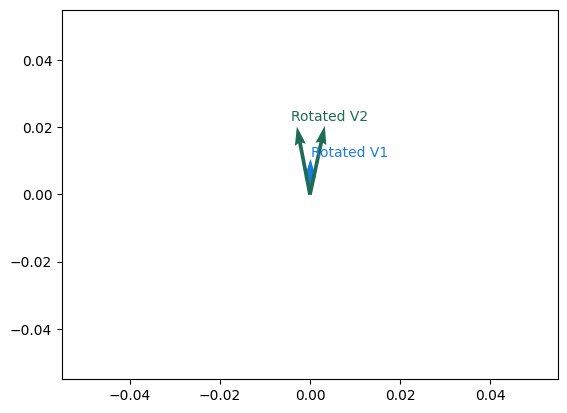

new_base tensor(90000.)


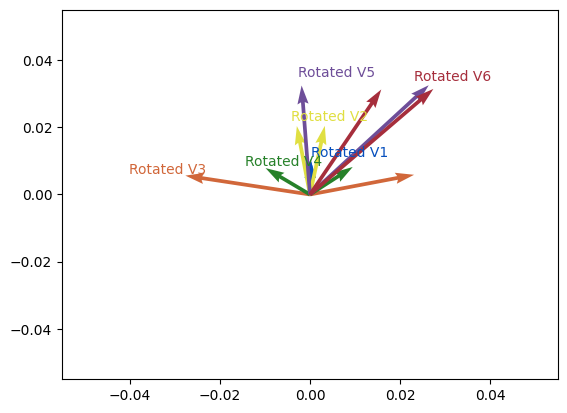

In [19]:
plot_rope_scale_comparision()

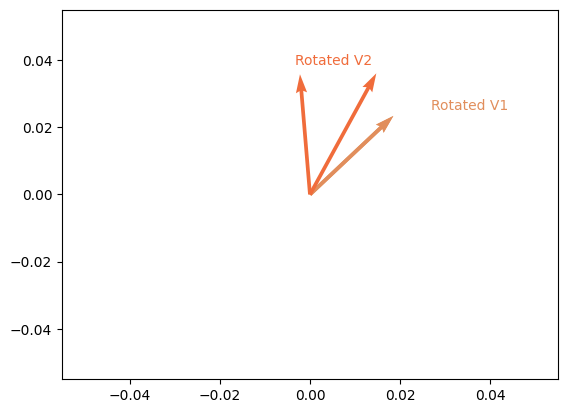

new_base tensor(67600.0078)


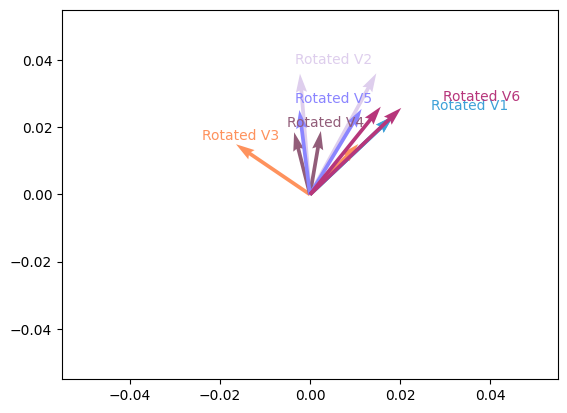

In [20]:
plot_rope_scale_comparision(scaling_factor=0.8)

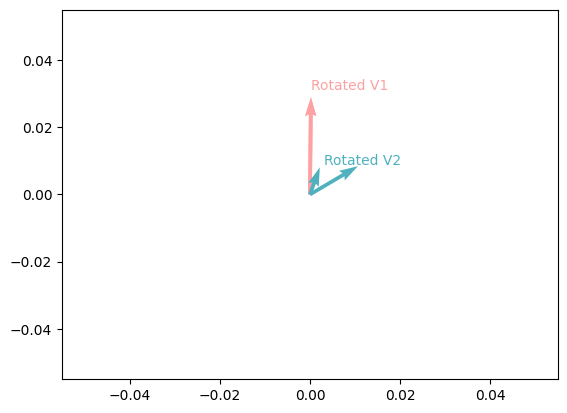

new_base tensor(25600.0020)


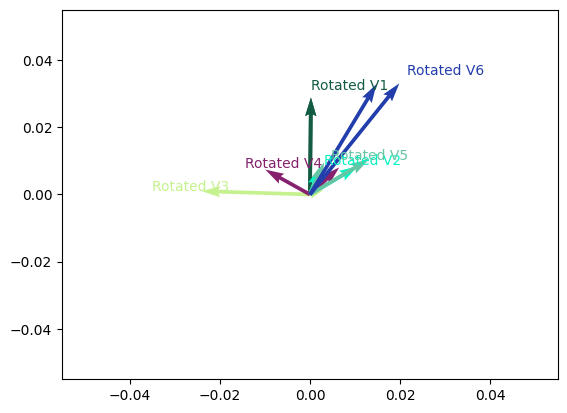

In [21]:
plot_rope_scale_comparision(scaling_factor=0.3)

## will the angle between two vectors get altered?

Yes, **the angle between two vectors will be altered** by applying the Rotary Position Embedding (RoPE). 

### Explanation:
Rotary Position Embeddings (RoPE) apply a **position-dependent rotation** to each vector in the sequence. Since the rotation applied to each vector depends on its position in the sequence, different vectors at different positions undergo **different rotations**. As a result, even though the magnitudes of the vectors remain unchanged, the angles between them can (and typically will) change.

### Why the Angle Changes:

When two vectors are rotated by different angles, the relative orientation between them is no longer preserved, which changes the angle between the vectors. Here's a breakdown of what happens:

#### Angle Before RoPE:
If you have two vectors, $\mathbf{v}_1$ and $\mathbf{v}_2$, the angle $\theta$ between them can be computed using the dot product formula:
$$\cos(\theta) = \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{|\mathbf{v}_1||\mathbf{v}_2|}$$
Where:
- $ \mathbf{v}_1 \cdot \mathbf{v}_2$ is the dot product.
- $|\mathbf{v}_1|$ and $|\mathbf{v}_2|$ are the magnitudes of the vectors.

#### Angle After RoPE:
RoPE applies a **position-dependent rotation** to both vectors:
$$\mathbf{v}_1 \rightarrow \mathbf{v}_{1, \text{rotated}} \quad \text{and} \quad \mathbf{v}_2 \rightarrow \mathbf{v}_{2, \text{rotated}}$$
The angle between the rotated vectors $\mathbf{v}_{1, \text{rotated}} \) and \( \mathbf{v}_{2, \text{rotated}}$ will change if different rotations are applied to $\mathbf{v}_1$ and $\mathbf{v}_2$. The rotation is determined by their position in the sequence, so unless both vectors are at the same position (and hence undergo the same rotation), their relative angle will change.

#### Visual Example:

Imagine rotating one vector by 30 degrees and another by 60 degrees. Even if the vectors were initially aligned or at a certain angle, after different rotations, the angle between them will be different.

### Geometric Interpretation:
- RoPE rotates the vectors in their feature space based on their position in the sequence.
- Since the amount of rotation differs from one position to another, two vectors at different positions will experience **different rotations**, altering their relative angle.
